# Agentic RAG with Multiple Tools

Complete implementation of multi-source Agentic RAG following the `1-AgenticRAG_langraph.ipynb` architecture.

**Features:**
- 6 Different Tools (URL, PDF, Text, Wikipedia, Arxiv, DuckDuckGo)
- Custom Graph Architecture with Agent Decision Making
- Document Relevance Grading
- Query Rewriting
- Answer Generation

## 1. Setup and Configuration

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
print("✓ Environment loaded")

✓ Environment loaded


## 2. Initialize LLM

In [2]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)
response = llm.invoke("Hello! Say hi in one sentence.")
print(response.content)
print("\n✓ LLM initialized")

c:\Agentic_AI_Projects\Multi_source_tool_retriever_using_langgraph\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Hello, it's nice to meet you, how can I assist you today?

✓ LLM initialized


## 3. Create All Tools

### 3.1 URL Retriever Tool (LangGraph Docs)

In [3]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.tools.retriever import create_retriever_tool

# URLs to load
URLS = [
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://langchain-ai.github.io/langgraph/how-tos/map-reduce/"
]

print("Loading URLs...")
docs_list = []
for url in URLS:
    try:
        docs = WebBaseLoader(url).load()
        docs_list.extend(docs)
        print(f"✓ Loaded: {url}")
    except Exception as e:
        print(f"✗ Failed: {url}")

# Split and vectorize
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
doc_splits = text_splitter.split_documents(docs_list)
vectorstore = FAISS.from_documents(
    documents=doc_splits,
    embedding=HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
)
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

url_retriever_tool = create_retriever_tool(
    retriever,
    "langgraph_docs_search",
    "Search for information about LangGraph. Use this for questions about LangGraph concepts, tutorials, and features."
)

print(f"\n✓ URL Retriever Tool created ({len(doc_splits)} chunks)")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Loading URLs...
✓ Loaded: https://langchain-ai.github.io/langgraph/tutorials/introduction/
✓ Loaded: https://langchain-ai.github.io/langgraph/tutorials/workflows/
✓ Loaded: https://langchain-ai.github.io/langgraph/how-tos/map-reduce/

✓ URL Retriever Tool created (3 chunks)


### 3.2 PDF Retriever Tool (Agent Quality Whitepaper)

In [4]:
from pathlib import Path
from langchain_community.document_loaders import PyPDFLoader

PDF_PATH = Path("data/Agent Quality Whitepaper.pdf")

if PDF_PATH.exists():
    loader = PyPDFLoader(str(PDF_PATH))
    pdf_docs = loader.load()
    pdf_splits = text_splitter.split_documents(pdf_docs)
    pdf_vectorstore = FAISS.from_documents(
        documents=pdf_splits,
        embedding=HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    )
    pdf_retriever = pdf_vectorstore.as_retriever(search_kwargs={"k": 4})
    
    pdf_retriever_tool = create_retriever_tool(
        pdf_retriever,
        "pdf_search",
        "Search the Agent Quality Whitepaper PDF. Use for questions about agent quality."
    )
    print(f"✓ PDF Retriever Tool created ({len(pdf_splits)} chunks)")
else:
    pdf_retriever_tool = None
    print("✗ PDF not found")

✓ PDF Retriever Tool created (98 chunks)


### 3.3 Text Retriever Tool (About Abhiram)

In [5]:
from langchain_community.document_loaders import TextLoader

TEXT_PATH = Path("data/about_me.txt")

if TEXT_PATH.exists():
    loader = TextLoader(str(TEXT_PATH))
    text_docs = loader.load()
    text_splits = text_splitter.split_documents(text_docs)
    text_vectorstore = FAISS.from_documents(
        documents=text_splits,
        embedding=HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    )
    text_retriever = text_vectorstore.as_retriever(search_kwargs={"k": 4})
    
    text_retriever_tool = create_retriever_tool(
        text_retriever,
        "about_abhiram_search",
        "Search information about Abhiram. Use for questions about Abhiram's background, experience, or profile."
    )
    print(f"✓ Text Retriever Tool created ({len(text_splits)} chunks)")
else:
    text_retriever_tool = None
    print("✗ Text file not found")

✓ Text Retriever Tool created (2 chunks)


### 3.4 Wikipedia Tool

In [6]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

try:
    wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
    wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)
    print("✓ Wikipedia Tool created")
except Exception as e:
    wikipedia_tool = None
    print(f"✗ Wikipedia tool failed: {e}")

✓ Wikipedia Tool created


### 3.5 Arxiv Tool

In [7]:
from langchain_community.tools import ArxivQueryRun
from langchain_community.utilities import ArxivAPIWrapper

try:
    arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=500)
    arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)
    print("✓ Arxiv Tool created")
except Exception as e:
    arxiv_tool = None
    print(f"✗ Arxiv tool failed: {e}")

✓ Arxiv Tool created


### 3.6 DuckDuckGo Search Tool

In [8]:
from langchain_community.tools import DuckDuckGoSearchRun

try:
    duckduckgo_tool = DuckDuckGoSearchRun()
    print("✓ DuckDuckGo Tool created")
except Exception as e:
    duckduckgo_tool = None
    print(f"✗ DuckDuckGo tool failed: {e}")

✓ DuckDuckGo Tool created


### 3.7 Collect All Tools

In [9]:
# Collect all working tools
tools = [
    url_retriever_tool,
    pdf_retriever_tool,
    text_retriever_tool,
    wikipedia_tool,
    arxiv_tool,
    duckduckgo_tool
]

# Filter out None values
tools = [t for t in tools if t is not None]

print(f"\n{'='*60}")
print(f"Total working tools: {len(tools)}")
print(f"{'='*60}")
for i, tool in enumerate(tools, 1):
    print(f"{i}. {tool.name}")


Total working tools: 6
1. langgraph_docs_search
2. pdf_search
3. about_abhiram_search
4. wikipedia
5. arxiv
6. duckduckgo_search


## 4. Define Agent State

In [10]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """Agent state with messages"""
    messages: Annotated[list[BaseMessage], add_messages]

print("✓ Agent State defined")

✓ Agent State defined


## 5. Define Graph Nodes

### 5.1 Agent Node

In [11]:
from langchain_core.messages import HumanMessage, AIMessage

def agent(state):
    """
    Invokes the agent model to generate a response based on the current state.
    Decides whether to retrieve using tools or simply end.
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = llm.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]}

print("✓ Agent node defined")

✓ Agent node defined


### 5.2 Generate Node

In [12]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

def generate(state):
    """
    Generate answer using retrieved documents
    """
    print("---GENERATE---")
    messages = state["messages"]
    
    # Get question from user messages
    user_messages = [m for m in messages if isinstance(m, HumanMessage)]
    question = user_messages[-1].content if user_messages else messages[0].content
    
    # Get retrieved documents from last message
    last_message = messages[-1]
    docs = last_message.content
    
    # RAG Prompt
    prompt = PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

Question: {question}

Context: {context}

Answer:""",
        input_variables=["question", "context"],
    )
    
    # Chain
    rag_chain = prompt | llm | StrOutputParser()
    
    # Generate
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [AIMessage(content=response)]}

print("✓ Generate node defined")

✓ Generate node defined


### 5.3 Rewrite Node

In [13]:
def rewrite(state):
    """
    Transform the query to produce a better question.
    """
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    
    # Get question
    user_messages = [m for m in messages if isinstance(m, HumanMessage)]
    question = user_messages[-1].content if user_messages else messages[0].content
    
    msg = [
        HumanMessage(
            content=f"""Look at the input and try to reason about the underlying semantic intent / meaning.
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]
    
    response = llm.invoke(msg)
    return {"messages": [response]}

print("✓ Rewrite node defined")

✓ Rewrite node defined


## 6. Define Edge Functions

### 6.1 Grade Documents Edge

In [14]:
from typing import Literal
from pydantic import BaseModel, Field

def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.
    """
    print("---CHECK RELEVANCE---")
    
    # Data model for grading
    class grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")
    
    # LLM with structured output
    llm_with_tool = llm.with_structured_output(grade)
    
    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question.
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )
    
    # Chain
    chain = prompt | llm_with_tool
    
    messages = state["messages"]
    last_message = messages[-1]
    
    # Get question
    user_messages = [m for m in messages if isinstance(m, HumanMessage)]
    question = user_messages[-1].content if user_messages else messages[0].content
    
    docs = last_message.content
    
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score
    
    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewrite"

print("✓ Grade documents edge defined")

✓ Grade documents edge defined


## 7. Build the Graph

In [ ]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)
retrieve = ToolNode(tools)
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)

# Set entry point
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    },
)

# After retrieval, grade documents
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
)

# Connect generate and rewrite to end/agent
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

print("✓ Graph compiled successfully!")

✓ Graph compiled successfully!


## 8. Visualize Graph (Optional)

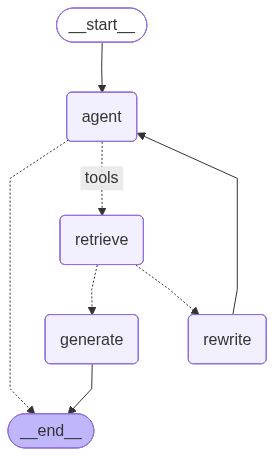

In [16]:
try:
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not visualize graph: {e}")

## 9. Test the Agent

### 9.1 Helper Function

In [23]:
def ask_agent(question: str):
    """
    Ask the agent a question and print the response with tool usage info
    """
    print(f"\n{'='*60}")
    print(f"Question: {question}")
    print(f"{'='*60}\n")
    
    result = graph.invoke(
        {"messages": [HumanMessage(content=question)]},
        config={"recursion_limit": 25}
    )
    
    # Extract tool calls
    messages = result["messages"]
    tools_used = []
    
    for msg in messages:
        if hasattr(msg, 'tool_calls') and msg.tool_calls:
            for tool_call in msg.tool_calls:
                tool_name = tool_call.get('name', 'unknown')
                if tool_name not in tools_used:
                    tools_used.append(tool_name)
    
    # Display tools used
    if tools_used:
        print(f"🔧 Tools Used: {', '.join(tools_used)}")
        print(f"📊 Total Steps: {len(messages)}\n")
    
    # Extract final response
    for msg in reversed(messages):
        if isinstance(msg, AIMessage):
            content = msg.content
            if content and not content.startswith('<'):
                print(f"Answer: {content}\n")
                break
    
    return result

print("✓ Helper function defined")

✓ Helper function defined


### 9.2 Test: LangGraph Question

In [24]:
result1 = ask_agent("What is LangGraph and what are its main features?")


Question: What is LangGraph and what are its main features?

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
---TRANSFORM QUERY---
---CALL AGENT---
🔧 Tools Used: langgraph_docs_search
📊 Total Steps: 5

Answer: Based on the input, it seems like the question is asking for a general overview of LangGraph, which is likely a software or tool related to language processing or graph-based data structures.

An improved question could be:

"What is LangGraph, and what are its key capabilities and functionalities in the context of language processing or graph-based data analysis?"

This revised question is more specific and provides a clearer direction for the response, which can help to elicit a more detailed and accurate answer.



### 9.3 Test: Agent Quality Question

In [25]:
if pdf_retriever_tool:
    result2 = ask_agent("What are the key metrics for measuring agent quality?")
else:
    print("Skipping - PDF tool not available")


Question: What are the key metrics for measuring agent quality?

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---
🔧 Tools Used: pdf_search
📊 Total Steps: 4

Answer: The key metrics for measuring agent quality include Correctness & Accuracy, Trajectory Adherence, Safety & Responsibility, and Helpfulness & Relevance. These metrics assess the quality of the agent's reasoning and final output. They are derived by applying a judgment layer on top of raw observability data.



### 9.4 Test: Personal Information

In [26]:
if text_retriever_tool:
    result3 = ask_agent("Tell me about Abhiram's background and experience")
else:
    print("Skipping - Text retriever not available")


Question: Tell me about Abhiram's background and experience

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---
🔧 Tools Used: about_abhiram_search
📊 Total Steps: 4

Answer: Abhiram Soni is a data scientist and Agentic AI engineer from Chatra, Jharkhand, India. He holds a Bachelor's degree in Mathematics and is currently pursuing a Master's in Computer Science with a specialization in Data Science and Artificial Intelligence. Abhiram has experience working on various impactful projects, including web-based interactive agents, fraud detection, and recommendation systems.



### 9.5 Test: General Knowledge

In [21]:
result4 = ask_agent("What is machine learning?")


Question: What is machine learning?

---CALL AGENT---


### 9.6 Test: Mixed Query

In [22]:
result5 = ask_agent("How does LangGraph handle state management?")


Question: How does LangGraph handle state management?

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
---TRANSFORM QUERY---
---CALL AGENT---
Answer: Based on the input, I would formulate an improved question as follows:

"What mechanisms and strategies does LangGraph employ for managing state, including data persistence, caching, and concurrency control, and how do these approaches impact the overall performance and scalability of the system?"

This improved question:

1. Clarifies the scope of the inquiry by specifying the aspects of state management (data persistence, caching, concurrency control).
2. Provides more context about the desired outcome (performance and scalability).
3. Encourages a more detailed and comprehensive response from the person answering the question.

By asking a more specific and well-defined question, you are more likely to receive a clear and informative answer that addresses your underlying concerns and needs.



## Summary

### Architecture Overview:
- **Agent Node**: Decides whether to use tools or respond directly
- **Retrieve Node**: Executes selected tools to gather information
- **Grade Documents**: Assesses if retrieved docs are relevant
- **Generate Node**: Creates answer from relevant documents
- **Rewrite Node**: Reformulates query if docs aren't relevant

### Tools Integrated:
1. URL Retriever (LangGraph documentation)
2. PDF Retriever (Agent Quality Whitepaper)
3. Text Retriever (About Abhiram)
4. Wikipedia Search
5. Arxiv Research Papers
6. DuckDuckGo Web Search

### Key Features:
- ✅ Multi-source RAG with 6 different tools
- ✅ Intelligent tool selection by agent
- ✅ Document relevance grading
- ✅ Automatic query rewriting for better results
- ✅ Clean, modular architecture following reference notebook

### Next Steps:
- Implement this architecture in modular Python code
- Add more tools as needed
- Create Streamlit UI for better interaction